In [10]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import datetime
import email.utils as eutils
import time

import eppy as eppy
from eppy import modeleditor
from eppy.modeleditor import IDF
from eppy.runner.run_functions import runIDFs
import PySimpleGUI as sg
from PIL import Image, ImageTk
import os
from eppy.results import readhtml # the eppy module with functions to read the html
import subprocess
import os
from os import system

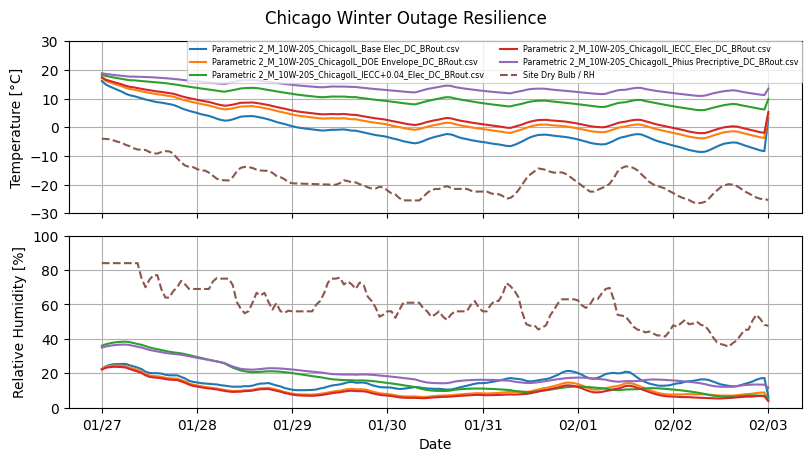

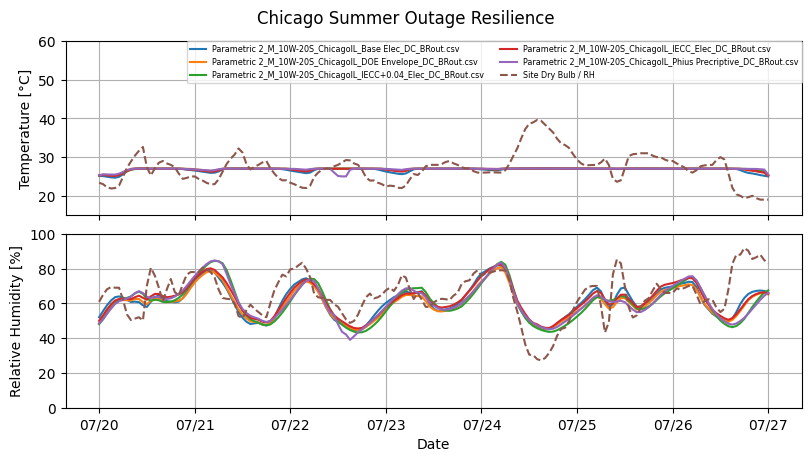

In [14]:
os.chdir('C:/Users/amitc_crl/OneDrive/Documents/GitHub/IIT-PhD/IBPSA Reslience Paper/heating outage 1')

if os.path.exists("Chicago_Cooling Outage Resilience Graphs.png"):
    os.remove("Chicago_Cooling Outage Resilience Graphs.png")
if os.path.exists("Chicago_Heating Outage Resilience Graphs.png"):
    os.remove("Chicago_Heating Outage Resilience Graphs.png")
files = os.listdir()

df1 = pd.DataFrame()

master_df = pd.read_csv(files[0])

df1 = pd.concat([df1,master_df[['Date/Time','Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)',
                               'Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly)',
                               'Environment:Site Outdoor Air Relative Humidity [%](Hourly)']]])

for file in files:
    df = pd.read_csv(file)
    file = file.replace('IBPSA_ChicagoIL_','')
    file = file.replace('_BR_eplusout.csv','')
    df = df.rename(columns={"ZONE 1:Zone Air Temperature [C](Hourly)": (str(file)+'_DB'), 
                       "ZONE 1:Zone Mean Air Dewpoint Temperature [C](Hourly)": (str(file)+'_DP'),
                       "ZONE 1:Zone Air Relative Humidity [%](Hourly)": (str(file)+'_RH'),})
    columns = []
    for column in list(df):
        if '_DB' in str(column):
            columns.append(column)
        if '_DP' in str(column):
            columns.append(column)
        if '_RH' in str(column):
            columns.append(column)
    df.reset_index(drop=True, inplace=True)
    df1 = pd.concat([df1,df[columns].reset_index()],axis=1)



df1.rename(columns = {'Date/Time':'DateTime'}, inplace = True)
df1[['Date2','Time']] = df1.DateTime.str.split(expand=True)
df1['Date'] = df1['Date2'].map(str) + '/' + str(2020)
df1['Time'] = (pd.to_numeric(df1['Time'].str.split(':').str[0])-1).astype(str).apply(lambda x: f'0{x}' if len(x)==1 else x) + df1['Time'].str[2:]
df1['DateTime'] = df1['Date'] + ' ' + df1['Time']
df1['DateTime'] = pd.to_datetime(df1['DateTime'])

endWarmup = int((df1[df1['DateTime'] == '2020-01-01 00:00:00'].index.values))
dropWarmup = [*range(0, endWarmup,1)]

df1 = df1.drop(index = dropWarmup)
df1 = df1.reset_index()

#Plot Heating Outage
start_date = '1/27/2020 0:00'
end_date = '2/3/2020 0:00'
start_date2 = '7/20/2020 0:00'
end_date2 = '7/27/2020 0:00'

#=============================================================================================

mask = (df1['DateTime'] >= start_date) & (df1['DateTime'] <= end_date)

dfh = df1.loc[mask]

x = dfh['DateTime']
heatingBattery = []
db = dict()
rh = dict()

fig = plt.figure(layout='constrained', figsize=(8, 4.5))
fig.suptitle(('Chicago Winter Outage Resilience'), fontsize='large')
ax = fig.subplot_mosaic([['temperature'],['rh']])

for file in files:
    file = file.replace('IBPSA_ChicagoIL_','')
    file = file.replace('_BR_eplusout.csv','')
    db[file] = dfh[(str(file)+ '_DB')]
    rh[file] = dfh[(str(file)+'_RH')]
    ax['temperature'].plot(x,db[file], label=(str(file)))
    ax['rh'].plot(x,rh[file], label=(str(file) + "_Zone RH"))

#Plot site temp    
ax['temperature'].plot(x,dfh["Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)"], label="Site Dry Bulb / RH", linestyle='dashed')
ax['rh'].plot(x,dfh["Environment:Site Outdoor Air Relative Humidity [%](Hourly)"], label="Site Relative Humidity [%]", linestyle='dashed')

#fig.subplots_adjust(bottom=0.1)
ax['temperature'].set_ylabel('Temperature [°C]')
ax['temperature'].set_ylim(-30,30)
ax['temperature'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['temperature'].grid(True)


ax['rh'].set_xlabel('Date')
ax['rh'].set_ylim(0,100)
ax['rh'].set_ylabel('Relative Humidity [%]')
# ax['rh'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['rh'].grid(True)
ax['temperature'].tick_params(labelbottom = False)
ax['rh'].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

# plt.savefig("Chicago_Heating Outage Resilience Graphs.png", dpi=600)

#Plot Cooling Outage
mask = (df1['DateTime'] >= start_date2) & (df1['DateTime'] <= end_date2)

dfh = df1.loc[mask]

x = dfh['DateTime']
heatingBattery = []
db = dict()
rh = dict()

fig = plt.figure(layout='constrained', figsize=(8, 4.5))
fig.suptitle(('Chicago Summer Outage Resilience'), fontsize='large')
ax = fig.subplot_mosaic([['temperature'],['rh']])

for file in files:
    file = file.replace('IBPSA_ChicagoIL_','')
    file = file.replace('_BR_eplusout.csv','')
    db[file] = dfh[(str(file)+ '_DB')]
    rh[file] = dfh[(str(file)+'_RH')]
    ax['temperature'].plot(x,db[file], label=(str(file)))
    ax['rh'].plot(x,rh[file], label=(str(file) + "_Zone RH"))

#Plot site temp    
ax['temperature'].plot(x,dfh["Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)"], label="Site Dry Bulb / RH", linestyle='dashed')
ax['rh'].plot(x,dfh["Environment:Site Outdoor Air Relative Humidity [%](Hourly)"], label="Site Relative Humidity [%]", linestyle='dashed')

#fig.subplots_adjust(bottom=0.1)
ax['temperature'].set_ylabel('Temperature [°C]')
ax['temperature'].set_ylim(15,60)
ax['temperature'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['temperature'].grid(True)

ax['rh'].set_xlabel('Date')
ax['rh'].set_ylim(0,100)
ax['rh'].set_ylabel('Relative Humidity [%]')
# ax['rh'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['rh'].grid(True)
ax['temperature'].tick_params(labelbottom = False)
ax['rh'].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

# plt.savefig("Chicago_Cooling Outage Resilience Graphs.png", dpi=600)


In [12]:
os.chdir('C:/Users/amitc_crl/OneDrive/Documents/GitHub/IIT-PhD/IBPSA Reslience Paper/outage6')

if os.path.exists("Chicago_Cooling Outage Resilience Graphs.png"):
    os.remove("Chicago_Cooling Outage Resilience Graphs.png")
if os.path.exists("Chicago_Heating Outage Resilience Graphs.png"):
    os.remove("Chicago_Heating Outage Resilience Graphs.png")
files = os.listdir()

df1 = pd.DataFrame()

master_df = pd.read_csv(files[0])

df1 = pd.concat([df1,master_df[['Date/Time','Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)',
                               'Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly)',
                               'Environment:Site Outdoor Air Relative Humidity [%](Hourly)']]])

for file in files:
    df = pd.read_csv(file)
    file = file.replace('IBPSA_M_20W-50S_ChicagoIL_','')
    file = file.replace('_BR_eplusout.csv','')
    df = df.rename(columns={"ZONE 1:Zone Air Temperature [C](Hourly)": (str(file)+'_DB'), 
                       "ZONE 1:Zone Mean Air Dewpoint Temperature [C](Hourly)": (str(file)+'_DP'),
                       "ZONE 1:Zone Air Relative Humidity [%](Hourly)": (str(file)+'_RH'),})
    columns = []
    for column in list(df):
        if '_DB' in str(column):
            columns.append(column)
        if '_DP' in str(column):
            columns.append(column)
        if '_RH' in str(column):
            columns.append(column)
    df.reset_index(drop=True, inplace=True)
    df1 = pd.concat([df1,df[columns].reset_index()],axis=1)



df1.rename(columns = {'Date/Time':'DateTime'}, inplace = True)
df1[['Date2','Time']] = df1.DateTime.str.split(expand=True)
df1['Date'] = df1['Date2'].map(str) + '/' + str(2020)
df1['Time'] = (pd.to_numeric(df1['Time'].str.split(':').str[0])-1).astype(str).apply(lambda x: f'0{x}' if len(x)==1 else x) + df1['Time'].str[2:]
df1['DateTime'] = df1['Date'] + ' ' + df1['Time']
df1['DateTime'] = pd.to_datetime(df1['DateTime'])

endWarmup = int((df1[df1['DateTime'] == '2020-01-01 00:00:00'].index.values))
dropWarmup = [*range(0, endWarmup,1)]

df1 = df1.drop(index = dropWarmup)
df1 = df1.reset_index()

#Plot Heating Outage
start_date = '1/27/2020 0:00'
end_date = '2/3/2020 0:00'
start_date2 = '7/20/2020 0:00'
end_date2 = '7/27/2020 0:00'

#=============================================================================================

mask = (df1['DateTime'] >= start_date) & (df1['DateTime'] <= end_date)

dfh = df1.loc[mask]

x = dfh['DateTime']
heatingBattery = []
db = dict()
rh = dict()

fig = plt.figure(layout='constrained', figsize=(5, 4))
fig.suptitle(('Chicago Winter Outage Resilience'), fontsize='large')
ax = fig.subplot_mosaic([['temperature'],['rh']])

for file in files:
    file = file.replace('IBPSA_M_20W-50S_ChicagoIL_','')
    file = file.replace('_BR_eplusout.csv','')
    db[file] = dfh[(str(file)+ '_DB')]
    rh[file] = dfh[(str(file)+'_RH')]
    ax['temperature'].plot(x,db[file], label=(str(file)))
    ax['rh'].plot(x,rh[file], label=(str(file) + "_Zone RH"))

#Plot site temp    
ax['temperature'].plot(x,dfh["Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)"], label="Site Dry Bulb / RH", linestyle='dashed')
ax['rh'].plot(x,dfh["Environment:Site Outdoor Air Relative Humidity [%](Hourly)"], label="Site Relative Humidity [%]", linestyle='dashed')

#fig.subplots_adjust(bottom=0.1)
ax['temperature'].set_ylabel('Temperature [°C]')
ax['temperature'].set_ylim(-30,30)
ax['temperature'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['temperature'].grid(True)


ax['rh'].set_xlabel('Date')
ax['rh'].set_ylim(0,100)
ax['rh'].set_ylabel('Relative Humidity [%]')
# ax['rh'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['rh'].grid(True)
ax['temperature'].tick_params(labelbottom = False)
ax['rh'].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

plt.savefig("Chicago_Heating Outage Resilience Graphs.png", dpi=600)

#Plot Cooling Outage
mask = (df1['DateTime'] >= start_date2) & (df1['DateTime'] <= end_date2)

dfh = df1.loc[mask]

x = dfh['DateTime']
heatingBattery = []
db = dict()
rh = dict()

fig = plt.figure(layout='constrained', figsize=(5, 4))
fig.suptitle(('Chicago Summer Outage Resilience'), fontsize='large')
ax = fig.subplot_mosaic([['temperature'],['rh']])

for file in files:
    file = file.replace('IBPSA_M_20W-50S_ChicagoIL_','')
    file = file.replace('_BR_eplusout.csv','')
    db[file] = dfh[(str(file)+ '_DB')]
    rh[file] = dfh[(str(file)+'_RH')]
    ax['temperature'].plot(x,db[file], label=(str(file)))
    ax['rh'].plot(x,rh[file], label=(str(file) + "_Zone RH"))

#Plot site temp    
ax['temperature'].plot(x,dfh["Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)"], label="Site Dry Bulb / RH", linestyle='dashed')
ax['rh'].plot(x,dfh["Environment:Site Outdoor Air Relative Humidity [%](Hourly)"], label="Site Relative Humidity [%]", linestyle='dashed')

#fig.subplots_adjust(bottom=0.1)
ax['temperature'].set_ylabel('Temperature [°C]')
ax['temperature'].set_ylim(15,60)
ax['temperature'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['temperature'].grid(True)

ax['rh'].set_xlabel('Date')
ax['rh'].set_ylim(0,100)
ax['rh'].set_ylabel('Relative Humidity [%]')
# ax['rh'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['rh'].grid(True)
ax['temperature'].tick_params(labelbottom = False)
ax['rh'].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

plt.savefig("Chicago_Cooling Outage Resilience Graphs.png", dpi=600)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

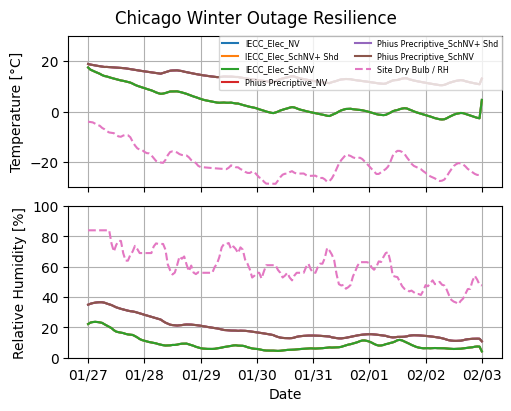

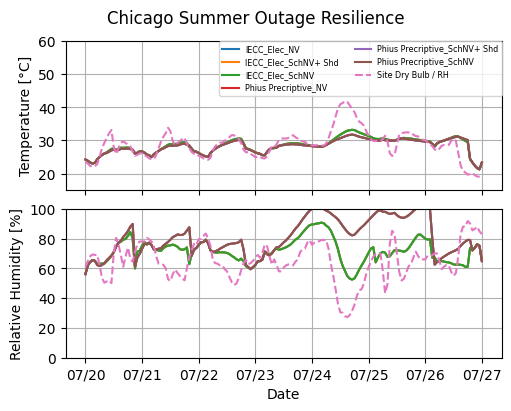

In [ ]:
os.chdir('C:/Users/amitc_crl/OneDrive/Documents/GitHub/IIT-PhD/IBPSA Reslience Paper/outage7')

if os.path.exists("Chicago_Cooling Outage Resilience Graphs.png"):
    os.remove("Chicago_Cooling Outage Resilience Graphs.png")
if os.path.exists("Chicago_Heating Outage Resilience Graphs.png"):
    os.remove("Chicago_Heating Outage Resilience Graphs.png")
files = os.listdir()

df1 = pd.DataFrame()

master_df = pd.read_csv(files[0])

df1 = pd.concat([df1,master_df[['Date/Time','Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)',
                               'Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly)',
                               'Environment:Site Outdoor Air Relative Humidity [%](Hourly)']]])

for file in files:
    df = pd.read_csv(file)
    file = file.replace('IBPSA_M_20W-50S_ChicagoIL_','')
    file = file.replace('_BR_eplusout.csv','')
    df = df.rename(columns={"ZONE 1:Zone Air Temperature [C](Hourly)": (str(file)+'_DB'), 
                       "ZONE 1:Zone Mean Air Dewpoint Temperature [C](Hourly)": (str(file)+'_DP'),
                       "ZONE 1:Zone Air Relative Humidity [%](Hourly)": (str(file)+'_RH'),})
    columns = []
    for column in list(df):
        if '_DB' in str(column):
            columns.append(column)
        if '_DP' in str(column):
            columns.append(column)
        if '_RH' in str(column):
            columns.append(column)
    df.reset_index(drop=True, inplace=True)
    df1 = pd.concat([df1,df[columns].reset_index()],axis=1)



df1.rename(columns = {'Date/Time':'DateTime'}, inplace = True)
df1[['Date2','Time']] = df1.DateTime.str.split(expand=True)
df1['Date'] = df1['Date2'].map(str) + '/' + str(2020)
df1['Time'] = (pd.to_numeric(df1['Time'].str.split(':').str[0])-1).astype(str).apply(lambda x: f'0{x}' if len(x)==1 else x) + df1['Time'].str[2:]
df1['DateTime'] = df1['Date'] + ' ' + df1['Time']
df1['DateTime'] = pd.to_datetime(df1['DateTime'])

endWarmup = int((df1[df1['DateTime'] == '2020-01-01 00:00:00'].index.values))
dropWarmup = [*range(0, endWarmup,1)]

df1 = df1.drop(index = dropWarmup)
df1 = df1.reset_index()

#Plot Heating Outage
start_date = '1/27/2020 0:00'
end_date = '2/3/2020 0:00'
start_date2 = '7/20/2020 0:00'
end_date2 = '7/27/2020 0:00'

#=============================================================================================

mask = (df1['DateTime'] >= start_date) & (df1['DateTime'] <= end_date)

dfh = df1.loc[mask]

x = dfh['DateTime']
heatingBattery = []
db = dict()
rh = dict()

fig = plt.figure(layout='constrained', figsize=(5, 4))
fig.suptitle(('Chicago Winter Outage Resilience'), fontsize='large')
ax = fig.subplot_mosaic([['temperature'],['rh']])

for file in files:
    file = file.replace('IBPSA_M_20W-50S_ChicagoIL_','')
    file = file.replace('_BR_eplusout.csv','')
    db[file] = dfh[(str(file)+ '_DB')]
    rh[file] = dfh[(str(file)+'_RH')]
    ax['temperature'].plot(x,db[file], label=(str(file)))
    ax['rh'].plot(x,rh[file], label=(str(file) + "_Zone RH"))

#Plot site temp    
ax['temperature'].plot(x,dfh["Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)"], label="Site Dry Bulb / RH", linestyle='dashed')
ax['rh'].plot(x,dfh["Environment:Site Outdoor Air Relative Humidity [%](Hourly)"], label="Site Relative Humidity [%]", linestyle='dashed')

#fig.subplots_adjust(bottom=0.1)
ax['temperature'].set_ylabel('Temperature [°C]')
ax['temperature'].set_ylim(-30,30)
ax['temperature'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['temperature'].grid(True)


ax['rh'].set_xlabel('Date')
ax['rh'].set_ylim(0,100)
ax['rh'].set_ylabel('Relative Humidity [%]')
# ax['rh'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['rh'].grid(True)
ax['temperature'].tick_params(labelbottom = False)
ax['rh'].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

plt.savefig("Chicago_Heating Outage Resilience Graphs.png", dpi=600)

#Plot Cooling Outage
mask = (df1['DateTime'] >= start_date2) & (df1['DateTime'] <= end_date2)

dfh = df1.loc[mask]

x = dfh['DateTime']
heatingBattery = []
db = dict()
rh = dict()

fig = plt.figure(layout='constrained', figsize=(5, 4))
fig.suptitle(('Chicago Summer Outage Resilience'), fontsize='large')
ax = fig.subplot_mosaic([['temperature'],['rh']])

for file in files:
    file = file.replace('IBPSA_M_20W-50S_ChicagoIL_','')
    file = file.replace('_BR_eplusout.csv','')
    db[file] = dfh[(str(file)+ '_DB')]
    rh[file] = dfh[(str(file)+'_RH')]
    ax['temperature'].plot(x,db[file], label=(str(file)))
    ax['rh'].plot(x,rh[file], label=(str(file) + "_Zone RH"))

#Plot site temp    
ax['temperature'].plot(x,dfh["Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)"], label="Site Dry Bulb / RH", linestyle='dashed')
ax['rh'].plot(x,dfh["Environment:Site Outdoor Air Relative Humidity [%](Hourly)"], label="Site Relative Humidity [%]", linestyle='dashed')

#fig.subplots_adjust(bottom=0.1)
ax['temperature'].set_ylabel('Temperature [°C]')
ax['temperature'].set_ylim(15,60)
ax['temperature'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['temperature'].grid(True)

ax['rh'].set_xlabel('Date')
ax['rh'].set_ylim(0,100)
ax['rh'].set_ylabel('Relative Humidity [%]')
# ax['rh'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['rh'].grid(True)
ax['temperature'].tick_params(labelbottom = False)
ax['rh'].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

plt.savefig("Chicago_Cooling Outage Resilience Graphs.png", dpi=600)


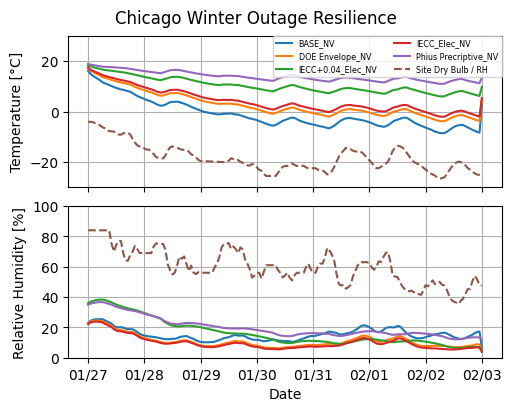

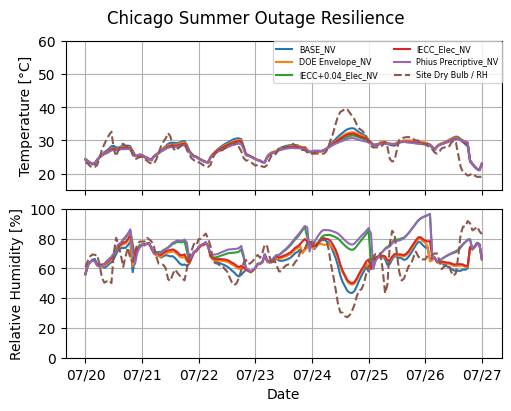

In [ ]:
os.chdir('C:/Users/amitc_crl/OneDrive/Documents/GitHub/IIT-PhD/IBPSA Reslience Paper/outage5')

if os.path.exists("Chicago_Cooling Outage Resilience Graphs.png"):
    os.remove("Chicago_Cooling Outage Resilience Graphs.png")
if os.path.exists("Chicago_Heating Outage Resilience Graphs.png"):
    os.remove("Chicago_Heating Outage Resilience Graphs.png")
files = os.listdir()

df1 = pd.DataFrame()

master_df = pd.read_csv(files[0])

df1 = pd.concat([df1,master_df[['Date/Time','Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)',
                               'Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly)',
                               'Environment:Site Outdoor Air Relative Humidity [%](Hourly)']]])

for file in files:
    df = pd.read_csv(file)
    file = file.replace('IBPSA_M_10W-20S_ChicagoIL_','')
    file = file.replace('_BR_eplusout.csv','')
    df = df.rename(columns={"ZONE 1:Zone Air Temperature [C](Hourly)": (str(file)+'_DB'), 
                       "ZONE 1:Zone Mean Air Dewpoint Temperature [C](Hourly)": (str(file)+'_DP'),
                       "ZONE 1:Zone Air Relative Humidity [%](Hourly)": (str(file)+'_RH'),})
    columns = []
    for column in list(df):
        if '_DB' in str(column):
            columns.append(column)
        if '_DP' in str(column):
            columns.append(column)
        if '_RH' in str(column):
            columns.append(column)
    df.reset_index(drop=True, inplace=True)
    df1 = pd.concat([df1,df[columns].reset_index()],axis=1)



df1.rename(columns = {'Date/Time':'DateTime'}, inplace = True)
df1[['Date2','Time']] = df1.DateTime.str.split(expand=True)
df1['Date'] = df1['Date2'].map(str) + '/' + str(2020)
df1['Time'] = (pd.to_numeric(df1['Time'].str.split(':').str[0])-1).astype(str).apply(lambda x: f'0{x}' if len(x)==1 else x) + df1['Time'].str[2:]
df1['DateTime'] = df1['Date'] + ' ' + df1['Time']
df1['DateTime'] = pd.to_datetime(df1['DateTime'])

endWarmup = int((df1[df1['DateTime'] == '2020-01-01 00:00:00'].index.values))
dropWarmup = [*range(0, endWarmup,1)]

df1 = df1.drop(index = dropWarmup)
df1 = df1.reset_index()

#Plot Heating Outage
start_date = '1/27/2020 0:00'
end_date = '2/3/2020 0:00'
start_date2 = '7/20/2020 0:00'
end_date2 = '7/27/2020 0:00'

#=============================================================================================

mask = (df1['DateTime'] >= start_date) & (df1['DateTime'] <= end_date)

dfh = df1.loc[mask]

x = dfh['DateTime']
heatingBattery = []
db = dict()
rh = dict()

fig = plt.figure(layout='constrained', figsize=(5, 4))
fig.suptitle(('Chicago Winter Outage Resilience'), fontsize='large')
ax = fig.subplot_mosaic([['temperature'],['rh']])

for file in files:
    file = file.replace('IBPSA_M_10W-20S_ChicagoIL_','')
    file = file.replace('_BR_eplusout.csv','')
    db[file] = dfh[(str(file)+ '_DB')]
    rh[file] = dfh[(str(file)+'_RH')]
    ax['temperature'].plot(x,db[file], label=(str(file)))
    ax['rh'].plot(x,rh[file], label=(str(file) + "_Zone RH"))

#Plot site temp    
ax['temperature'].plot(x,dfh["Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)"], label="Site Dry Bulb / RH", linestyle='dashed')
ax['rh'].plot(x,dfh["Environment:Site Outdoor Air Relative Humidity [%](Hourly)"], label="Site Relative Humidity [%]", linestyle='dashed')

#fig.subplots_adjust(bottom=0.1)
ax['temperature'].set_ylabel('Temperature [°C]')
ax['temperature'].set_ylim(-30,30)
ax['temperature'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['temperature'].grid(True)


ax['rh'].set_xlabel('Date')
ax['rh'].set_ylim(0,100)
ax['rh'].set_ylabel('Relative Humidity [%]')
# ax['rh'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['rh'].grid(True)
ax['temperature'].tick_params(labelbottom = False)
ax['rh'].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

plt.savefig("Chicago_Heating Outage Resilience Graphs.png", dpi=600)

#Plot Cooling Outage
mask = (df1['DateTime'] >= start_date2) & (df1['DateTime'] <= end_date2)

dfh = df1.loc[mask]

x = dfh['DateTime']
heatingBattery = []
db = dict()
rh = dict()

fig = plt.figure(layout='constrained', figsize=(5, 4))
fig.suptitle(('Chicago Summer Outage Resilience'), fontsize='large')
ax = fig.subplot_mosaic([['temperature'],['rh']])

for file in files:
    file = file.replace('IBPSA_M_10W-20S_ChicagoIL_','')
    file = file.replace('_BR_eplusout.csv','')
    db[file] = dfh[(str(file)+ '_DB')]
    rh[file] = dfh[(str(file)+'_RH')]
    ax['temperature'].plot(x,db[file], label=(str(file)))
    ax['rh'].plot(x,rh[file], label=(str(file) + "_Zone RH"))

#Plot site temp    
ax['temperature'].plot(x,dfh["Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)"], label="Site Dry Bulb / RH", linestyle='dashed')
ax['rh'].plot(x,dfh["Environment:Site Outdoor Air Relative Humidity [%](Hourly)"], label="Site Relative Humidity [%]", linestyle='dashed')

#fig.subplots_adjust(bottom=0.1)
ax['temperature'].set_ylabel('Temperature [°C]')
ax['temperature'].set_ylim(15,60)
ax['temperature'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['temperature'].grid(True)

ax['rh'].set_xlabel('Date')
ax['rh'].set_ylim(0,100)
ax['rh'].set_ylabel('Relative Humidity [%]')
# ax['rh'].legend(ncol=2, loc='upper right', borderaxespad=0, fontsize='xx-small')
ax['rh'].grid(True)
ax['temperature'].tick_params(labelbottom = False)
ax['rh'].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

plt.savefig("Chicago_Cooling Outage Resilience Graphs.png", dpi=600)


In [ ]:
os.chdir('C:/Users/amitc_crl/OneDrive/Documents/GitHub/IIT-PhD/IBPSA Reslience Paper')

single_points = pd.read_csv('IBPSA_ResultsTable.csv')

single_points.head()
# fig = plt.figure(layout='constrained', figsize=(5, 4))
# fig.suptitle(('Chicago Winter Outage Resilience'), fontsize='large')
# ax = fig.subplot_mosaic([['temperature'],['rh']])



,Unnamed: 0,Run Name,SET ≤ 12.2°C Hours (F),Hours < 2°C [hr],Total Deadly Days,Min outdoor DB [°C],Min outdoor DP [°C],Max outdoor DB [°C],Max outdoor DP [°C],"Caution (> 26.7, ≤ 32.2°C) [hr]",...,Mechanical Cost [$],Water Heater Cost [$],Appliances Cost [$],PV Cost [$],Battery Cost [$],pv_dirEn_tot,pv_dirMR_tot,pv_opCO2_tot,pv_emCO2_tot,pv_eTrans_tot
0,0,ChicagoIL_BASE_NV,997.99,118.08,2,-25.0,-32.075,39.625,24.25,66.50,...,0.0,0.0,0.0,0.0,0.00,86893.761521,11922.033456,35294.231013,4475.250000,9441.911729
1,1,ChicagoIL_Base Elec_NV,996.52,118.08,2,-25.0,-32.075,39.625,24.25,66.50,...,9500.0,1000.0,4474.0,15000.0,2381.74,95372.971996,51756.876594,14360.516112,11606.085270,41863.615690
2,2,ChicagoIL_DOE Envelope_NV,541.82,49.30,2,-25.0,-32.075,39.625,24.25,66.00,...,9500.0,1000.0,4596.0,15000.0,2050.73,65483.728772,57052.337378,8825.309692,12554.025705,27482.235679
3,3,ChicagoIL_IECC_Elec_NV,372.35,21.78,2,-25.0,-32.075,39.625,24.25,72.50,...,9500.0,1000.0,4596.0,15000.0,2050.73,58915.457517,61382.945221,7561.677195,13329.247815,25058.652233
4,4,ChicagoIL_IECC+0.04_Elec_NV,2.88,0.00,3,-25.0,-32.075,39.625,24.25,54.75,...,9500.0,1000.0,4596.0,15000.0,2050.73,38059.140707,64971.337378,3522.919845,13971.605895,11862.387666
